In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from scipy.io import mmread

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

## 1. Parameter settings

In [23]:
# 9-D latent space
latent_dims = 9
num_epochs = 100
learning_rate = 1e-3
variational_beta = 1
batch_size = 1000

## 2. VAE definition

In [24]:
class Encoder(nn.Module):
    
    def __init__(self, layer_size_list, output_size):
        
        super(Encoder, self).__init__()
        
        # Define hidden layers
        self.hidden = nn.ModuleList()
        for k in range(len(layer_size_list)-1):
            self.hidden.append(nn.Linear(layer_size_list[k], layer_size_list[k+1]))
       
        # fc_mu layer and fc_logvar
        self.fc_mu = nn.Linear(in_features=layer_size_list[-1], out_features=output_size)
        self.fc_logvar = nn.Linear(in_features=layer_size_list[-1], out_features=output_size)
        
    def forward(self, x):
        
        # Feedforward        
        for k in range(len(self.hidden)-1):
            x = F.relu(self.hidden[k](x))

        # Generate output before mu and logvar
        x = self.hidden[-1](x)

        # Generate fc_mu and fc_logvar
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)

        return x_mu, x_logvar

    
class Decoder(nn.Module):
    
    def __init__(self, input_size, layer_size_list_reversed):
        
        super(Decoder, self).__init__()
        
        # Output layer to first hidden layer
        self.input = nn.Linear(output_size, layer_size_list_reversed[0])

        # Define hidden layers
        self.hidden = nn.ModuleList()
        for k in range(len(layer_size_list_reversed)-1):
            self.hidden.append(nn.Linear(layer_size_list_reversed[k], layer_size_list_reversed[k+1]))
                   
    def forward(self, x):
        
        # Feedforward
        
        x = self.input(x)
        
        for k in range(len(self.hidden)-1):
            x = F.relu(self.hidden[k](x))

        x = self.hidden[-1](x)
        
        return x

    
class VariationalAutoencoder(nn.Module):
    
    def __init__(self, layer_size_list, output_size, input_size, layer_size_list_reversed):
        
        super(VariationalAutoencoder, self).__init__()
        
        self.encoder = Encoder(layer_size_list, output_size)
        self.decoder = Decoder(input_size, layer_size_list_reversed)
    
    def forward(self, x):
        
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        
        if self.training:
            
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        
        else:
            
            return mu


def vae_loss(recon_x, x, mu, logvar):
    
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence

In [25]:
# Encoder parameters
layer_size_list = [32738, 50, 25]
output_size = latent_dims

# Decoder parameters
input_size = latent_dims
layer_size_list_reversed = [25, 50, 32738]

vae = VariationalAutoencoder(layer_size_list, output_size, input_size, layer_size_list_reversed)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 3309881


## 3. Load data and train VAE

In [5]:
# Change directory

print("Original working directory: {0}".format(os.getcwd()))

path = '/Users/ryanyutian/Desktop/PBMC68k_project/input_data_pure/all'

try:
    os.chdir(path)
    print("Current working directory: {0}".format(os.getcwd()))
except FileNotFoundError:
    print("Directory: {0} does not exist".format(path))
except NotADirectoryError:
    print("{0} is not a directory".format(path))
except PermissionError:
    print("You do not have permissions to change to {0}".format(path))

Original working directory: /Users/ryanyutian/Desktop/PBMC68k_project/python_scripts
Current working directory: /Users/ryanyutian/Desktop/PBMC68k_project/input_data_pure/all


In [6]:
# Obtain all normalized expression arrays and save their variable names for later use 

normalized_expression_pure_array_names = []

for file_name in sorted([i for i in os.listdir(path) if i.startswith('normalized_expression')]):
    
    print('Analyzing: ' + file_name)
    print('Current Time =', datetime.now().strftime("%H:%M:%S"))
    
    # Import sparse matrix of normalized expression then turn into np.array
    # (e.g., 'normalized_expression_1' would be mtx for all normalized expressions for cell type 1)
    temp_mtx = mmread(file_name)
    
    array_name = file_name[:-4]
    globals()[array_name] = temp_mtx.toarray(order='C')

    # Add name of the global array variable to the list of names
    normalized_expression_pure_array_names.append(array_name)

Analyzing: normalized_expression_1.mtx
Current Time = 18:24:20
Analyzing: normalized_expression_10.mtx
Current Time = 18:24:37
Analyzing: normalized_expression_2.mtx
Current Time = 18:24:39
Analyzing: normalized_expression_3.mtx
Current Time = 18:24:48
Analyzing: normalized_expression_4.mtx
Current Time = 18:24:57
Analyzing: normalized_expression_5.mtx
Current Time = 18:25:07
Analyzing: normalized_expression_6.mtx
Current Time = 18:25:18
Analyzing: normalized_expression_7.mtx
Current Time = 18:25:28
Analyzing: normalized_expression_8.mtx
Current Time = 18:25:38
Analyzing: normalized_expression_9.mtx
Current Time = 18:25:46


In [7]:
normalized_expression_pure_array_names.remove('normalized_expression_10')

In [8]:
# Concatenate all the normalized expression arrays to generate input data and labels

normalized_expression_pure_array = []
cell_labels_pure = []

for array_name in normalized_expression_pure_array_names:

    for cell in globals()[array_name]:
        
        # Append the expression profile of each cell
        normalized_expression_pure_array.append(cell)
        
        # Append label of the cell based on array name (e.g., 10, 11, ...etc.)
        # Note that -1 is applied to all labels due to R to Python transition
        cell_labels_pure.append(int(array_name.split('_')[2]) - 1)
    
normalized_expression_pure_array = np.array(normalized_expression_pure_array)
cell_labels_pure = np.array(cell_labels_pure)

In [26]:
# Split training and testing set from the pure data

X_train, X_test, y_train, y_test = \
train_test_split(normalized_expression_pure_array, cell_labels_pure, test_size=0.20)

In [27]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([7411, 6753, 8365, 8182, 9538, 8170, 8103, 8107, 9005]))

In [28]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([1821, 1632, 2114, 2081, 2415, 2054, 2106, 1978, 2208]))

In [29]:
train_data = []
for i in range(len(X_train)):
    train_data.append([X_train[i], y_train[i]])

trainloader = DataLoader(train_data, shuffle=True, batch_size=100)

In [30]:
test_data = []
for i in range(len(X_test)):
    test_data.append([X_test[i], y_test[i]])

testloader = DataLoader(test_data, shuffle=True, batch_size=100)

In [31]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

train_loss_avg = []
test_loss_avg = []

print('Training ...')

for epoch in range(num_epochs):
    
    # set to training mode
    vae.train()

    train_loss_avg.append(0)
    num_batches = 0
    
    for cell_batch, _ in trainloader:
        
        # vae reconstruction
        x_recon, latent_mu, latent_logvar = vae(cell_batch.to(torch.float32))
        
        # reconstruction error
        loss = vae_loss(x_recon, cell_batch.to(torch.float32), latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
    
    # Update test performance every 50 epochs
    if epoch == 0 or (epoch + 1) % 50 == 0:
        
        # set to testing mode
        vae.eval()
        
        test_loss_avg.append(0)
        num_batches = 0

        for cell_batch, _ in testloader:

            # vae reconstruction
            x_recon, latent_mu, latent_logvar = vae(cell_batch.to(torch.float32))

            # reconstruction error
            loss = vae_loss(x_recon, cell_batch.to(torch.float32), latent_mu, latent_logvar)

            test_loss_avg[-1] += loss.item()
            num_batches += 1

        test_loss_avg[-1] /= num_batches

        print('Epoch [%d / %d] average testing reconstruction error: %f' % (epoch+1, num_epochs, test_loss_avg[-1]))
        print('Current time: ', datetime.now().strftime("%H:%M:%S"))

Training ...
Epoch [1 / 100] average reconstruction error: 1738.922490
Epoch [1 / 100] average testing reconstruction error: 25.072674
Current time:  09:38:15
Epoch [2 / 100] average reconstruction error: 10.346063
Epoch [3 / 100] average reconstruction error: 0.647902
Epoch [4 / 100] average reconstruction error: 0.187387
Epoch [5 / 100] average reconstruction error: 0.167144
Epoch [6 / 100] average reconstruction error: 0.137439
Epoch [7 / 100] average reconstruction error: 0.136988
Epoch [8 / 100] average reconstruction error: 0.132989
Epoch [9 / 100] average reconstruction error: 0.154454
Epoch [10 / 100] average reconstruction error: 0.160365
Epoch [11 / 100] average reconstruction error: 0.212523
Epoch [12 / 100] average reconstruction error: 0.225304
Epoch [13 / 100] average reconstruction error: 0.274510
Epoch [14 / 100] average reconstruction error: 0.223986
Epoch [15 / 100] average reconstruction error: 0.223694
Epoch [16 / 100] average reconstruction error: 0.249454
Epoch [1

In [32]:
# Save trained model

path = '/Users/ryanyutian/Desktop/PBMC68k_project/models/50_25_9_VAE/50_25_9_VAE.pt'

torch.save(vae.state_dict(), path)

In [33]:
# Save model performance

output_df_dict = {'training_loss_avg': train_loss_avg, 'testing_loss_avg': test_loss_avg}
output_df = pd.DataFrame.from_dict(output_df_dict, orient='index')

path = '/Users/ryanyutian/Desktop/PBMC68k_project/models/50_25_9_VAE'
output_df.to_csv((path + '/'  'performance.csv'), sep=',')

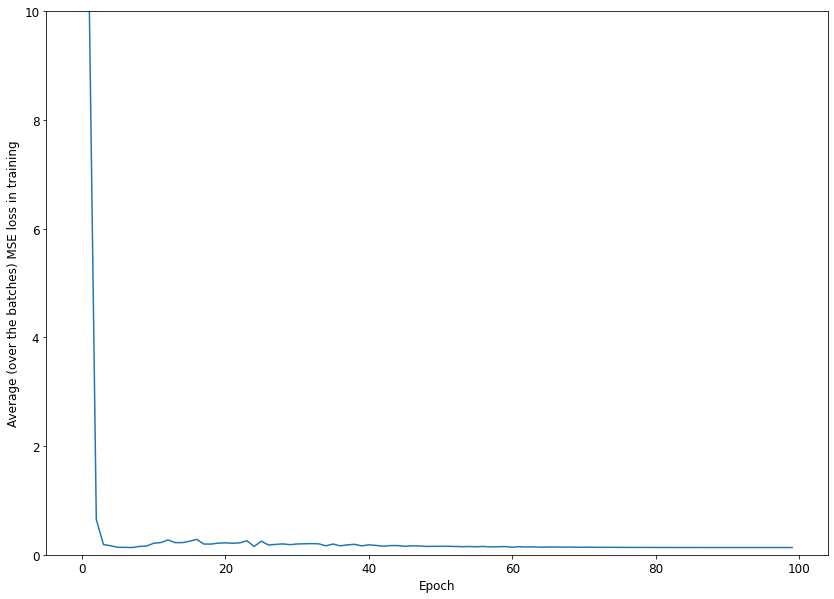

In [37]:
# Plot training MSE loss over 100 epochs

plt.figure(figsize =(14, 10))
plt.rcParams.update({'font.size': 12})

_ = plt.plot(np.arange(0,100,1), train_loss_avg)

_ = plt.ylabel('Average (over the batches) MSE loss in training')
_ = plt.xlabel('Epoch')
_ = plt.ylim([0, 10])

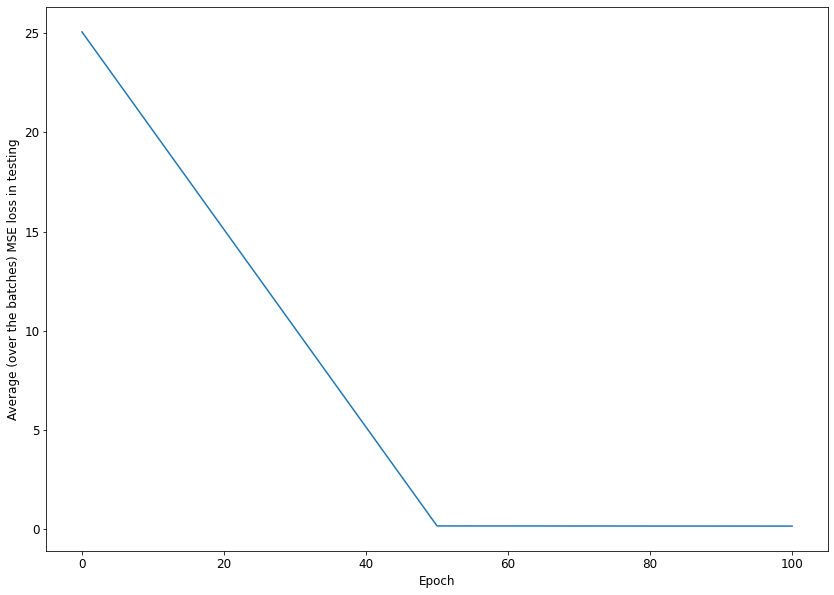

In [40]:
# Plot testing MSE loss over 100 epochs

plt.figure(figsize =(14, 10))
plt.rcParams.update({'font.size': 12})

_ = plt.plot(np.arange(0,101,50), test_loss_avg)

_ = plt.ylabel('Average (over the batches) MSE loss in testing')
_ = plt.xlabel('Epoch')

## 4. Reconstructing classes from latent space 

In [66]:
vae.eval()

# Get latent space vectors 
# (for each sample, there is a 9 dimensional vector of mu,
# and a 9 dimensional vector of logvar describing the distribution)
latent_mu, latent_logvar = vae.encoder(torch.from_numpy(normalized_expression_pure_array).to(torch.float32))

In [90]:
# Construct a np.array as training dataset
latent_vars = []

for i in range(len(latent_mu)):
    
    temp_row = np.concatenate((latent_mu[i].detach().numpy(), latent_logvar[i].detach().numpy()), axis=None)
    latent_vars.append(temp_row)
    
latent_vars = np.array(latent_vars)

In [91]:
latent_vars.shape

(92043, 18)

In [69]:
# Define Neural Network architecture
class MLPNNet(nn.Module):
   
    def __init__(self, layer_size_list, output_size):
       
        super(MLPNNet, self).__init__()
        
        # Save some model parameters
        self.input_size = layer_size_list[0]
        self.output_size = output_size
        
        # Define hidden layers
        self.hidden = nn.ModuleList()
        for k in range(len(layer_size_list)-1):
            self.hidden.append(nn.Linear(layer_size_list[k], layer_size_list[k+1]))
       
        # Last hidden layer to output layer
        self.out = nn.Linear(layer_size_list[-1], output_size)
       
    # ReLu activation function used for hidden layers
    def forward(self, x):
        
        # Feedforward
        for layer in self.hidden:
            x = F.relu(layer(x))

        # Generate output
        output= self.out(x)
        
        return output

In [70]:
def get_label_from_MLP_output(output):
    
    # Apply softmax function to get probability for each class (one-hot encoding)
    pred = F.softmax(output, dim = 1)
    
    # Convert prediction back to numpy array
    MLP_dec = pred.detach().numpy()
    
    # Get predicted labels from probabilities
    MLP_predicted_labels = np.argmax(MLP_dec, axis=1)

    return MLP_predicted_labels

In [92]:
# Split training and testing set from the pure data

X_train, X_test, y_train, y_test = \
train_test_split(latent_vars, cell_labels_pure, test_size=0.20)

In [93]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([7388, 6718, 8360, 8220, 9545, 8183, 8161, 8047, 9012]))

In [94]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([1844, 1667, 2119, 2043, 2408, 2041, 2048, 2038, 2201]))

In [95]:
# Initialize a very simple MLP to map latent space to class labels
model = MLPNNet([18, 10], 9)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Number of times that the MLP will be trained on the train set
n_epochs = 500

# Lists to record model training and testing performance
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

print('Training ...')

# Loop through the training set to update parameters
for epoch in range(n_epochs):
    
    # Train the model
    model.train()

    # Get an output by feeding data into the model
    out = model(torch.from_numpy(X_train).float())

    # Compute loss from output
    loss = criterion(out, torch.from_numpy(np.asarray(y_train)).long())

    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Update weights
    optimizer.step()

    # Update training performance
    train_loss.append(float(loss))
    train_accuracy.append(np.mean(get_label_from_MLP_output(out) == y_train))
    
    print('Epoch [%d / %d] average training loss: %f' % (epoch+1, n_epochs, train_loss[-1]))

    # Update other performance lists every 10 epochs
    if epoch % 10 == 0:
                              
        # Evaluate the trained MLP model with test data
        model.eval()

        # Get raw predicted result
        test_pred = model(torch.from_numpy(X_test).float())
        
        # Append test loss
        test_loss.append(float(criterion(test_pred, torch.from_numpy(np.asarray(y_test)).long())))

        # Get predicted labels 
        MLP_predicted_labels = get_label_from_MLP_output(test_pred)
        temp_test_accuracy = np.mean(MLP_predicted_labels == y_test)
        test_accuracy.append(temp_test_accuracy)
        
    # Print statement every 50 epochs to verify status and time taken
    if epoch == 0 or (epoch + 1) % 50 == 0:
        
        print('Current epoch: ' + str(epoch + 1))
        print('Current time: ', datetime.now().strftime("%H:%M:%S"))
        print('Train accuracy = ' + str(train_accuracy[-1]))
        print('Test accuracy = ' + str(temp_test_accuracy))

Training ...
Epoch [1 / 500] average training loss: 2.215245
Current epoch: 1
Current time:  01:10:53
Train accuracy = 0.11113072765298639
Test accuracy = 0.11086968330707805
Epoch [2 / 500] average training loss: 2.215067
Epoch [3 / 500] average training loss: 2.214797
Epoch [4 / 500] average training loss: 2.213942
Epoch [5 / 500] average training loss: 2.214393
Epoch [6 / 500] average training loss: 2.214180
Epoch [7 / 500] average training loss: 2.213320
Epoch [8 / 500] average training loss: 2.213287
Epoch [9 / 500] average training loss: 2.212961
Epoch [10 / 500] average training loss: 2.212606
Epoch [11 / 500] average training loss: 2.211511
Epoch [12 / 500] average training loss: 2.211603
Epoch [13 / 500] average training loss: 2.212183
Epoch [14 / 500] average training loss: 2.211896
Epoch [15 / 500] average training loss: 2.210937
Epoch [16 / 500] average training loss: 2.209842
Epoch [17 / 500] average training loss: 2.210506
Epoch [18 / 500] average training loss: 2.209602


Epoch [166 / 500] average training loss: 2.193166
Epoch [167 / 500] average training loss: 2.193119
Epoch [168 / 500] average training loss: 2.193419
Epoch [169 / 500] average training loss: 2.193493
Epoch [170 / 500] average training loss: 2.193480
Epoch [171 / 500] average training loss: 2.193152
Epoch [172 / 500] average training loss: 2.193136
Epoch [173 / 500] average training loss: 2.193644
Epoch [174 / 500] average training loss: 2.193638
Epoch [175 / 500] average training loss: 2.193438
Epoch [176 / 500] average training loss: 2.193367
Epoch [177 / 500] average training loss: 2.193428
Epoch [178 / 500] average training loss: 2.193324
Epoch [179 / 500] average training loss: 2.193340
Epoch [180 / 500] average training loss: 2.193308
Epoch [181 / 500] average training loss: 2.193303
Epoch [182 / 500] average training loss: 2.193307
Epoch [183 / 500] average training loss: 2.193257
Epoch [184 / 500] average training loss: 2.193239
Epoch [185 / 500] average training loss: 2.193018


Epoch [333 / 500] average training loss: 2.192575
Epoch [334 / 500] average training loss: 2.192575
Epoch [335 / 500] average training loss: 2.192575
Epoch [336 / 500] average training loss: 2.192575
Epoch [337 / 500] average training loss: 2.192575
Epoch [338 / 500] average training loss: 2.192575
Epoch [339 / 500] average training loss: 2.192579
Epoch [340 / 500] average training loss: 2.192579
Epoch [341 / 500] average training loss: 2.192579
Epoch [342 / 500] average training loss: 2.192579
Epoch [343 / 500] average training loss: 2.192579
Epoch [344 / 500] average training loss: 2.192579
Epoch [345 / 500] average training loss: 2.192579
Epoch [346 / 500] average training loss: 2.192579
Epoch [347 / 500] average training loss: 2.192579
Epoch [348 / 500] average training loss: 2.192579
Epoch [349 / 500] average training loss: 2.192579
Epoch [350 / 500] average training loss: 2.192585
Current epoch: 350
Current time:  01:10:58
Train accuracy = 0.1296276176766168
Test accuracy = 0.130

## Task failed, model could not use the latent space to predict original labels
## The classification project will thus only focus on the successful MLP models thereafter